# Calculating calibration densities and plotting models at UCB
- This workbook shows how we calculate densities for calibration data, plot models and calculate the cali lines

In [14]:
# Import useful python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import os
import datetime

## Downloading DiadFit locally
- The easiest way to install diad fit is by removing the #. It will install from PyPI
- You only need to do this once on each computer, or run in order to grab an updated version. 

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [15]:
import DiadFit as pf
pf.__version__

'0.0.62'

## Plot of density vs fermi splitting

In [16]:
input_file_path=os.getcwd()+'\Input_files'

cornellpath=input_file_path+'/'+"1-s2.0-S0009254121004654-mmc1.xlsx"
PW_data_path=input_file_path+'/'+"merged_df_wrho_PWdata.xlsx"

April_data_path=input_file_path+'/'+"merged_df_wrho-4-10-23.xlsx"
HPjune_data_path=input_file_path+'/'+"merged_df_wrho-6-7-23.xlsx"
MPjune_HPsens_data_path=input_file_path+'/'+"merged_df_wrho-6-8-23.xlsx"

cornellcell=pd.read_excel(cornellpath)
display(cornellcell.head())

,Date,time,Date group,Raw file name,Sample type,v- position (cm-1),v+ position (cm-1),∆CO2 (cm-1),Ne corrected ∆CO2 (cm-1),P(Median-MPa),...,WANG vs EOS,LAM vs EOS,Neon data,1122 peak position (cm-1),1453 peak position (cm-1),∆Ne-m (cm-1),∆Ne-r (cm-1),1122 r (cm-1),1453 r (cm-1),"Comments (power-mW, integrationxaccumulations, associated Ne)"
0,11/29/2020,1900-01-01 01:20:58,NOV_2020,POC58,FDCA,1286.7182,1389.4400,102.7218,102.7817,0.037,...,0.020605,0.047001,NaN,1123.4561,1453.7410,330.2849,330.477634,1122.776289,1453.253923,56.590X5NE77
1,11/29/2020,1900-01-01 01:10:45,NOV_2020,POC57,FDCA,1286.7205,1389.4383,102.7178,102.7844,0.040,...,0.021512,0.047899,NaN,1123.4697,1453.7333,330.2636,330.477634,1122.776289,1453.253923,56.590X5NE76
2,11/29/2020,1900-01-01 00:54:26,NOV_2020,POC55,FDCA,1286.7079,1389.4321,102.7242,102.7868,0.061,...,0.022023,0.048400,NaN,1123.4566,1453.7330,330.2764,330.477634,1122.776289,1453.253923,56.590X3NE74
3,11/29/2020,1900-01-01 00:46:57,NOV_2020,POC54,FDCA,1286.6881,1389.4193,102.7312,102.7939,0.070,...,0.024418,0.050759,NaN,1123.4597,1453.7359,330.2762,330.477634,1122.776289,1453.253923,56.590X3NE72
4,09/18/2020,9:58:56 PM,SEPT_2020,CUC31,FDCA,1286.0110,1388.7926,102.7816,102.8011,0.083,...,0.026791,0.053084,NaN,1122.6997,1453.1146,330.4149,330.477600,1122.776300,1453.253900,Ne41


In [17]:
april_data=pd.read_excel(April_data_path)
april_data=april_data.drop(columns=[col for col in april_data.columns if 'Unnamed' in col])
april_data.head()



,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr,filename_merge,filename_split,T_C_mean,T_C_std,rho_gmL
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,62.4879,37.002,37.006,37.011,37.012,...,62.489000,0.000706,31.603516,0.002679,003 FDCA-P1-1,FDCA-P1-1,FDCA-P1,37.0086,0.004450,1.034183
1,FDCA-P1-2,NaN,NaN,NaN,NaN,62.4730,37.016,37.014,37.012,37.013,...,62.473144,0.001202,31.611328,0.002685,005 FDCA-P1-2,FDCA-P1-2,FDCA-P1,37.0138,0.001483,1.034131
2,FDCA-P1-3,NaN,NaN,NaN,NaN,62.4508,36.997,37.001,37.004,37.005,...,62.452215,0.001161,31.642578,0.003603,007 FDCA-P1-3,FDCA-P1-3,FDCA-P1,37.0024,0.003435,1.034108
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,59.2656,36.989,36.989,36.988,36.987,...,59.265227,0.001133,31.650391,0.004547,009 FDCA-P2-1,FDCA-P2-1,FDCA-P2,36.9882,0.000837,1.026057
4,FDCA-P2-2,NaN,NaN,NaN,NaN,59.2523,37.001,37.003,37.005,37.007,...,59.250048,0.001667,31.667969,0.003524,011 FDCA-P2-2,FDCA-P2-2,FDCA-P2,37.0060,0.005000,1.025970


In [18]:
hpjune=pd.read_excel(HPjune_data_path)
hpjune=hpjune.drop(columns=[col for col in hpjune.columns if 'Unnamed' in col])
hpjune.head()



,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr,filename_split,T_C_mean,T_C_std,rho_gmL
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,66.4600,36.970,36.970,36.970,36.970,...,2023-06-07 13:28:12.975,66.463879,0.000959,32.336914,0.001013,FDCA-P1-1,FDCA-P1,36.9700,0.000000,1.043839
1,FDCA-P1-2,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,...,2023-06-07 13:29:11.971,66.460425,0.001139,32.340820,0.000777,FDCA-P1-2,FDCA-P1,36.9700,0.000000,1.043831
2,FDCA-P1-3,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,...,2023-06-07 13:30:08.971,66.455936,0.001092,32.343750,0.001061,FDCA-P1-3,FDCA-P1,36.9700,0.000000,1.043820
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,60.1811,36.974,36.975,36.976,36.976,...,2023-06-07 13:44:36.974,60.179294,0.001203,32.389160,0.001302,FDCA-P2-1,FDCA-P2,36.9754,0.000894,1.028451
4,FDCA-P2-2,NaN,NaN,NaN,NaN,60.1815,36.976,36.977,36.978,36.979,...,2023-06-07 13:45:41.970,60.178839,0.001778,32.392578,0.000977,FDCA-P2-2,FDCA-P2,36.9778,0.001304,1.028444


In [19]:

lpmpjune=pd.read_excel(PW_data_path)
lpmpjune=lpmpjune.drop(columns=[col for col in lpmpjune.columns if 'Unnamed' in col])
lpmpjune['Corr_Split_1σ_val']=lpmpjune['Corr_Split+1σ']-lpmpjune['Corrected_Splitting']
lpmpjune.head()


,Corrected_Splitting,Corr_Split+1σ,Corr_Split-1σ,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,...,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp,ThermistorT_Av,ThermistorT_Std,AvP_Manuel,rho_gmL,Corr_Split_1σ_val
0,104.317427,104.319067,104.315787,12 C6_CRR_DiadFit,104.569330,0.002040,0.001474,1282.899792,0.001234,8503.996689,...,2023-06-01 12:16:41.050,10.0988,0.001109,31.3,2.486900e-14,37.01100,0.000707,10.09850,0.687860,0.001640
1,104.253899,104.255586,104.252212,14 C7_CRR_DiadFit,104.506344,0.002089,0.001527,1283.055183,0.001320,4159.640332,...,2023-06-01 12:31:20.110,9.4587,0.000416,31.5,0.000000e+00,37.00125,0.003031,9.45820,0.652035,0.001687
2,104.191284,104.193021,104.189548,16 C8,104.444319,0.002222,0.001583,1283.206389,0.001248,2439.022384,...,2023-06-01 12:47:41.210,9.0964,0.000834,31.8,2.486900e-14,37.00100,0.003391,9.09595,0.621071,0.001736
3,104.187881,104.189711,104.186050,17 C9,104.441140,0.002336,0.001687,1283.204984,0.001410,2470.540943,...,2023-06-01 12:52:59.240,9.1028,0.000600,31.8,2.486900e-14,37.00975,0.003419,9.10230,0.621495,0.001831
4,104.039708,104.041630,104.037786,19 C10,104.293657,0.002524,0.001787,1283.523492,0.001324,2413.101156,...,2023-06-01 13:17:50.360,8.6394,0.000121,32.2,3.688281e-02,37.00225,0.004146,8.63880,0.548014,0.001922


In [20]:
mpjune_hpsens=pd.read_excel(MPjune_HPsens_data_path)
mpjune_hpsens=mpjune_hpsens.drop(columns=[col for col in mpjune_hpsens.columns if 'Unnamed' in col])
mpjune_hpsens.head()

,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr,filename_merge,filename_split,T_C_mean,T_C_std,rho_gmL
0,FDCA-P28-1,0.095909,310.15,0.660905,9.590924,9.6752,36.975,36.976,36.976,36.976,...,9.673804,0.000595,32.446289,0.000977,58 FDCA-P28-1,FDCA-P28-1,58 FDCA-P28,36.9756,0.000548,0.666442
1,FDCA-P29-1,0.093876,310.15,0.646865,9.387566,9.4594,37.002,37.003,37.003,37.003,...,9.250386,0.000533,32.447266,0.001210,56 FDCA-P29-1,FDCA-P29-1,56 FDCA-P29,37.0028,0.000447,0.635696
2,FDCA-P30-1,0.092172,310.15,0.632824,9.217169,9.2497,36.978,36.980,36.981,36.982,...,9.253401,0.000711,32.433105,0.004123,55 FDCA-P30-1,FDCA-P30-1,55 FDCA-P30,36.9808,0.001924,0.636492
3,FDCA-P31-1,0.090746,310.15,0.618784,9.074609,9.0269,36.995,36.994,36.993,36.993,...,9.027366,0.000695,32.666016,0.001157,53 FDCA-P31-1,FDCA-P31-1,53 FDCA-P31,36.9932,0.001483,0.613721
4,FDCA-P32-1,0.089553,310.15,0.604743,8.955350,8.9823,37.015,37.015,37.015,37.016,...,8.981870,0.000870,32.707520,0.003147,52 FDCA-P32-1,FDCA-P32-1,52 FDCA-P32,37.0156,0.000894,0.607595


In [21]:
# This is to calculate the prediction of the cornell densimeter on our april data
rho_cornell=pf.calculate_density_cornell(temp='SupCrit', Split=april_data['Corrected_Splitting'])
april_data['cornellEQ_predrho']=rho_cornell['Preferred D']
april_data.head()

,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,mad_pressure,median_temp,mad_temp,filename_nocrr,filename_merge,filename_split,T_C_mean,T_C_std,rho_gmL,cornellEQ_predrho
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,62.4879,37.002,37.006,37.011,37.012,...,0.000706,31.603516,0.002679,003 FDCA-P1-1,FDCA-P1-1,FDCA-P1,37.0086,0.004450,1.034183,1.025790
1,FDCA-P1-2,NaN,NaN,NaN,NaN,62.4730,37.016,37.014,37.012,37.013,...,0.001202,31.611328,0.002685,005 FDCA-P1-2,FDCA-P1-2,FDCA-P1,37.0138,0.001483,1.034131,1.026039
2,FDCA-P1-3,NaN,NaN,NaN,NaN,62.4508,36.997,37.001,37.004,37.005,...,0.001161,31.642578,0.003603,007 FDCA-P1-3,FDCA-P1-3,FDCA-P1,37.0024,0.003435,1.034108,1.027984
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,59.2656,36.989,36.989,36.988,36.987,...,0.001133,31.650391,0.004547,009 FDCA-P2-1,FDCA-P2-1,FDCA-P2,36.9882,0.000837,1.026057,1.021067
4,FDCA-P2-2,NaN,NaN,NaN,NaN,59.2523,37.001,37.003,37.005,37.007,...,0.001667,31.667969,0.003524,011 FDCA-P2-2,FDCA-P2-2,FDCA-P2,37.0060,0.005000,1.025970,1.020977


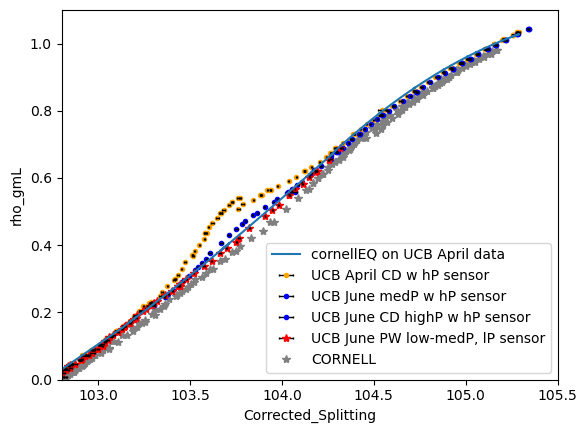

In [22]:
fig,ax=plt.subplots()

x='Corrected_Splitting'
y='rho_gmL'
y_pw='rho_gmL'
ax.errorbar(x=april_data[x],y=april_data[y], fmt='.',xerr=april_data['Corr_Split_1σ_val'],
             color='orange',mfc='orange', ecolor='black', capsize=1,elinewidth=1,barsabove=True,zorder=2,
           label='UCB April CD w hP sensor')

ax.errorbar(x=mpjune_hpsens[x],y=mpjune_hpsens[y], xerr=mpjune_hpsens['Corr_Split_1σ_val'], fmt='.',
             color='blue',mfc='blue', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
           label='UCB June medP w hP sensor')

ax.errorbar(x=hpjune[x],y=hpjune[y], xerr=hpjune['Corr_Split_1σ_val'], fmt='.',
             color='blue',mfc='blue', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
           label='UCB June CD highP w hP sensor')

ax.errorbar(x=lpmpjune[x],y=lpmpjune[y_pw], xerr=lpmpjune['Corr_Split_1σ_val'], fmt='*',
             color='red',mfc='red', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
           label='UCB June PW low-medP, lP sensor')

if os.path.exists(cornellpath):
  ax.errorbar(x=cornellcell['Ne corrected ∆CO2  (cm-1)'],y=cornellcell['Density from EOS  (g/ml)'], fmt='*',
              color='grey',mfc='grey', ecolor='black', capsize=1,barsabove=True,zorder=-2,
            label='CORNELL')

ax.plot(april_data[x],april_data['cornellEQ_predrho'],label='cornellEQ on UCB April data')

# ax2=ax.twinx()
# ax2.plot(april_data['Corrected_Splitting'],april_data['median_temp'],color='darkred')
# ax2.set_ylabel('Sensor_T')

ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_xlim([102.8,105.5])
ax.set_ylim([0,1.1])
plt.legend()


plt.show()

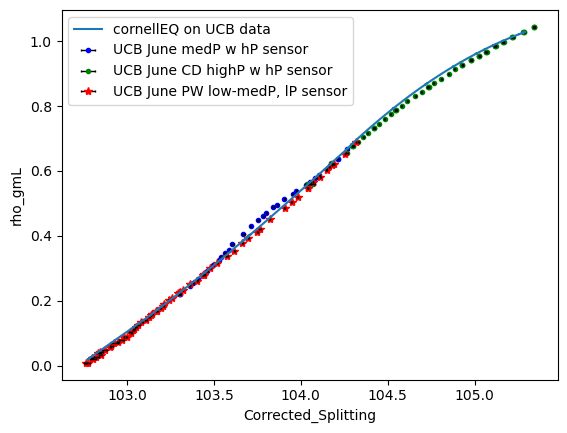

In [23]:
fig,ax=plt.subplots()

x='Corrected_Splitting'
y='rho_gmL'
y_pw='rho_gmL'

# ax.errorbar(x=april_data[x],y=april_data[y], fmt='.',xerr=april_data['Corr_Split_1σ_val'],
#              color='orange',mfc='orange', ecolor='black', capsize=1,elinewidth=1,barsabove=True,zorder=2,
#            label='UCB April CD w hP sensor')
ax.errorbar(x=mpjune_hpsens[x],y=mpjune_hpsens[y], xerr=mpjune_hpsens['Corr_Split_1σ_val'], fmt='.',
             color='blue',mfc='blue', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
           label='UCB June medP w hP sensor')

ax.errorbar(x=hpjune[x],y=hpjune[y], xerr=hpjune['Corr_Split_1σ_val'], fmt='.',
             color='green',mfc='green', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
           label='UCB June CD highP w hP sensor')

ax.errorbar(x=lpmpjune[x],y=lpmpjune[y_pw], xerr=lpmpjune['Corr_Split_1σ_val'], fmt='*',
             color='red',mfc='red', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
           label='UCB June PW low-medP, lP sensor')


ax.scatter(lpmpjune[x][lpmpjune[y_pw].between(0.46,0.48)],lpmpjune[y_pw][lpmpjune[y_pw].between(0.46,0.48)])

ax.plot(april_data[x],april_data['cornellEQ_predrho'],label='cornellEQ on UCB data')

# ax2=ax.twinx()
# ax2.plot(april_data['Corrected_Splitting'],april_data['median_temp'],color='darkred')
# ax2.set_ylabel('Sensor_T')

ax.set_xlabel(x)
ax.set_ylabel(y)
# ax.set_xlim([104,104.5])
# ax.set_ylim([0.63,0.75])
plt.legend()


plt.show()

# Now let's pick the points to build the calibration line 
- Here we get rid of a couple outliers, exclude the data from april (bad data due to sensor T) and merge data for fitting

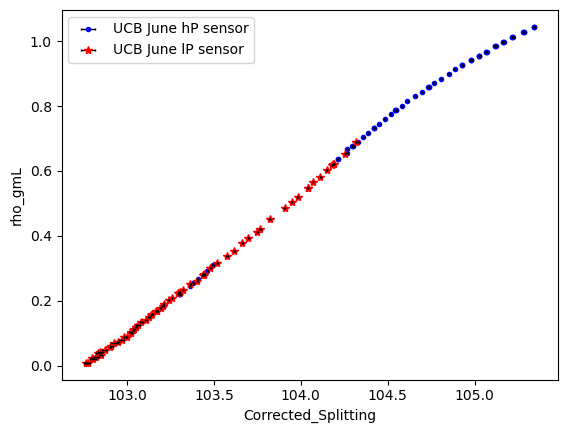

In [24]:
# Filter out bad ones from the high pressure sensor and concatenate the frames 
test=mpjune_hpsens.drop(columns=['Offset','filename_merge'])
hpsens_june=pd.concat([test,hpjune])

cali_pts_hpsens=hpsens_june[~(hpsens_june['rho_gmL'].between(0.325,0.63))]

# Filter out bad ones from low pressure sensor and concat frames
lpsens_june=lpmpjune.copy()
cali_pts_lpsens=lpsens_june[~(lpsens_june['rho_gmL'].between(0.46,0.48))]
cali_pts_lpsens = cali_pts_lpsens.replace([np.inf, -np.inf], np.nan)

cali_pts_lpsens = cali_pts_lpsens.dropna(subset=['rho_gmL'])

fig,ax=plt.subplots()

x='Corrected_Splitting'
y='rho_gmL'
y_pw='rho_gmL'


ax.errorbar(x=cali_pts_hpsens[x],y=cali_pts_hpsens[y], xerr=cali_pts_hpsens['Corr_Split_1σ_val'], fmt='.',
             color='blue',mfc='blue', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
           label='UCB June hP sensor')


ax.errorbar(x=cali_pts_lpsens[x],y=cali_pts_lpsens[y_pw], xerr=cali_pts_lpsens['Corr_Split_1σ_val'], fmt='*',
             color='red',mfc='red', ecolor='black', elinewidth=1,capsize=1,barsabove=True,zorder=2,
           label='UCB June lP sensor')

ax.set_xlabel(x)
ax.set_ylabel(y)

plt.legend()


plt.show()

## Merge the whole dataset for fitting

In [25]:
full=pd.concat([pd.DataFrame(data={'Split':cali_pts_hpsens[x],'rho':cali_pts_hpsens[y],'spliterr':cali_pts_hpsens['Corr_Split_1σ_val']}),pd.DataFrame(data={'Split':cali_pts_lpsens[x],'rho':cali_pts_lpsens[y_pw],'spliterr':cali_pts_lpsens['Corr_Split_1σ_val']})])
full_sort=full.sort_values('rho')
# plt.scatter(full_sort['Split'],full_sort['rho'])

## Fit the calibration lines 

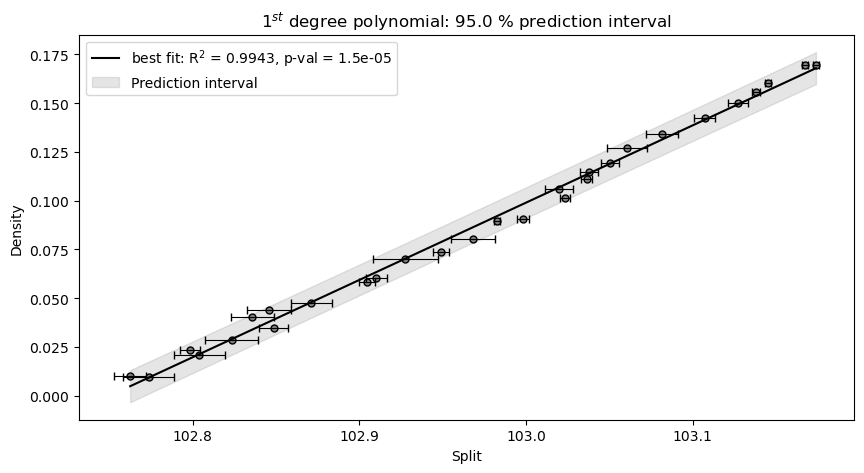

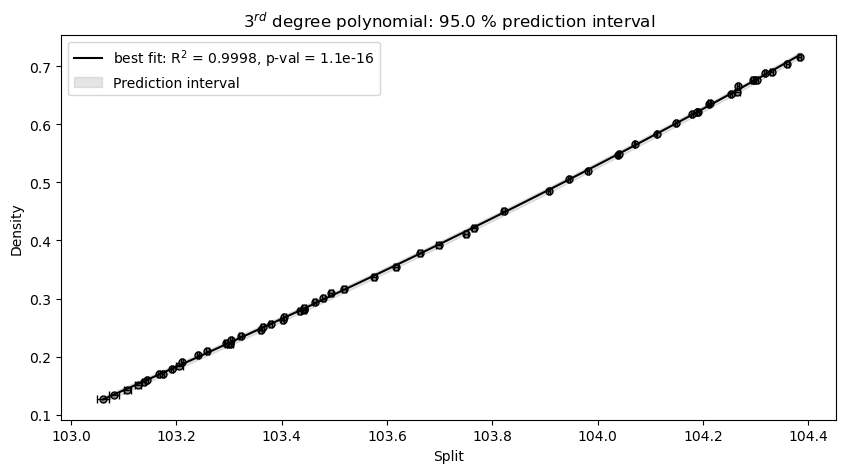

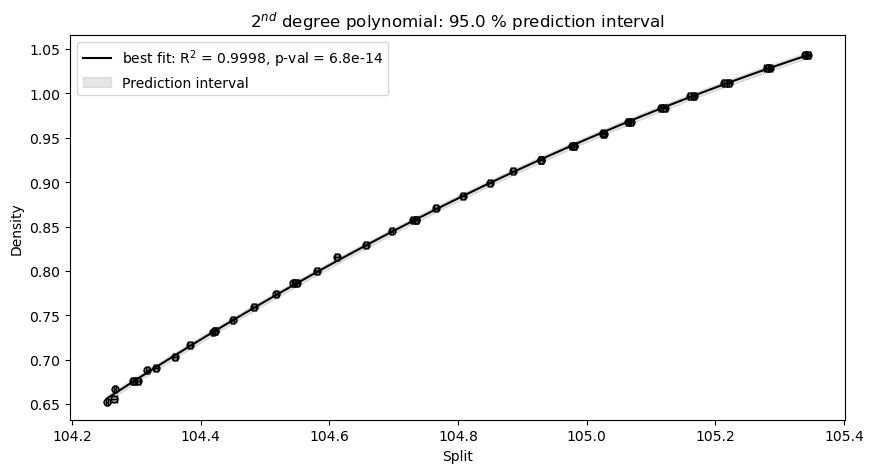

In [26]:
CI=0.95
pf.plot_and_save_CO2cali_pickle(cali_data=full_sort, density_range='Low',N_poly=1, CI=CI, std_error=True,save_fig=True)
pf.plot_and_save_CO2cali_pickle(cali_data=full_sort, density_range='Medium',N_poly=3, CI=CI, std_error=True,save_fig=True)
pf.plot_and_save_CO2cali_pickle(cali_data=full_sort, density_range='High',N_poly=2, CI=CI, std_error=True,save_fig=True)